# Pneumothorax Localization (Faster R-CNN)

## SIIM-ACR Dataset on Pneumothorax

- TODO: data augmentation using translate- crop and zoom-transforms

In [1]:
from data.dicom import DICOMFolderDataset

# balanced samples of the SIIM-ACR dataset
valid_data = DICOMFolderDataset('siim-acr-data/dev-pneumothorax/**/**/*.dcm', 'siim-acr-data/dev-sample.csv')
train_data = DICOMFolderDataset('siim-acr-data/train-pneumothorax/**/**/*.dcm', 'siim-acr-data/train-sample.csv')

### Pneumothorax Studies

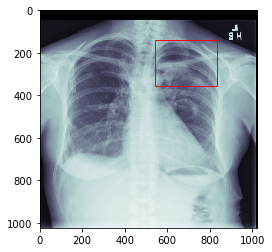

In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

fig,ax = plt.subplots(1)

# choose a study from the datset
data, label = valid_data.__getitem__(16)

img = data.asnumpy()*255
gtbox = label.asnumpy()

# chest xray image
ax.imshow(img, cmap=plt.cm.bone, interpolation='none')

# ground truth bounding box in corner format
gt = patches.Rectangle((gtbox[0], gtbox[1]), gtbox[2]-gtbox[0], gtbox[3]-gtbox[1], linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(gt)
plt.show()

In [3]:
gtbox

array([542., 140., 836., 358.], dtype=float32)

## Faster R-CNN Detection Network

In [5]:
import mxnet as mx
from network.rcnn import RoentgenFasterRCNN

ctx = mx.cpu(0)

data = mx.sym.var('data')
labels = mx.sym.var('labels')# change manually to corner format

pneumothorax = RoentgenFasterRCNN(2, iou_threshold=0.7, sizes=[0.25,0.15,0.05], ratios=[2,1,0.5], rpn_head=True)

# Kaiming initialization from uniform [-c,c] c = sqrt(2/Nin) 
pneumothorax.collect_params().initialize(mx.init.Xavier(factor_type='in', magnitude=0.44444), ctx=ctx)

bboxes,classes = pneumothorax(data)

AttributeError: 'AnchorBoxDecoder' object has no attribute 'batch_size'

In [3]:
import time
from mxnet import nd

study = 8
ctx = mx.cpu(0)

data, label = valid_data.__getitem__(study)
data = nd.broadcast_to(data.reshape(1,1,1024,1024),(2,1,1024,1024))
X = nd.array(data.reshape((2, 1, 1024, 1024)), ctx=ctx)

start_time = time.time()
bboxes,classes = pneumothorax(X)

## Region Proposal Network (RPN)

In [59]:
from mxnet import gluon

# Region Proposal Network trained on auxiliary RPN head
pneumothorax = gluon.nn.SymbolBlock.imports("model/roentgen-pneumothorax-rpn-symbol.json", ['data'], "model/roentgen-pneumothorax-rpn-0252.params", ctx=ctx)

In [60]:
pneumothorax

SymbolBlock(
<Symbol group [cls_scores, bbox_offsets]> : 1 -> 2
)

### Anchor Box Decoder

In [84]:
import itertools
import numpy as np

map_stride=32
sizes=[0.25,0.15,0.05]
ratios=[2,1,0.5]

archetypes = list(itertools.product(sizes,ratios))
anchor_boxes = nd.array([(size,size*ratio) for size, ratio in archetypes], dtype=np.float32, ctx=ctx)

dx = range(int(map_stride/2),int(1024),map_stride)
dy = range(int(map_stride/2),int(1024),map_stride)

anchor_points = list(itertools.product(dy,dx))
anchor_points = nd.array(anchor_points, dtype=np.float32, ctx=ctx)

anchor_points = anchor_points.transpose()/1024
anchor_points[[0, 1]] = anchor_points[[1, 0]]
anchor_points = anchor_points.reshape(2,32,32)

In [107]:
import time
from mxnet import nd

study = 5 # pick an x-ray in the dataset
data, label = train_data.__getitem__(study)

X = nd.array(data.reshape((1, 1, 1024, 1024)), ctx=ctx)

# anchor boxes (center format)
p = nd.broadcast_to(anchor_points.reshape(1,1,2,32,32), (1,9,2,32,32))
s = nd.broadcast_to(anchor_boxes.reshape(1,9,2,1,1),(1,9,2,32,32)) # aw = ah = s*sqrt(r)
A = nd.concat(p,s,dim=2)

# cls scores and bbox offsets
start_time = time.time()
s,b = pneumothorax(X)

# create prediction
s = nd.sigmoid(s)
B = A + b.reshape(1,9,4,32,32)
print("--- %.2f ms ---" % (time.time()*1000 - start_time*1000))

--- 13.06 ms ---


### Non-Maximum Suppression (NMS)

In [108]:
s.max()


[0.9979189]
<NDArray 1 @cpu(0)>

In [109]:
cond = s.reshape(-1) >= s.max()#0.001
cls = nd.contrib.boolean_mask(s.reshape(-1), cond)

### Proposal Bounding Box Decoder

In [110]:
x = nd.contrib.boolean_mask(B[:,:,0,:,:].reshape(-1), cond)
y = nd.contrib.boolean_mask(B[:,:,1,:,:].reshape(-1), cond)
w = nd.contrib.boolean_mask(B[:,:,2,:,:].reshape(-1), cond)
h = nd.contrib.boolean_mask(B[:,:,3,:,:].reshape(-1), cond)

In [111]:
bbox = []

for n in range(cls.size):
    bbox.append(nd.array([x[n].asscalar(),y[n].asscalar(),w[n].asscalar(),h[n].asscalar()])*1024)

In [112]:
bbox

[
 [342.3679   200.68361  167.33426  101.508896]
 <NDArray 4 @cpu(0)>]

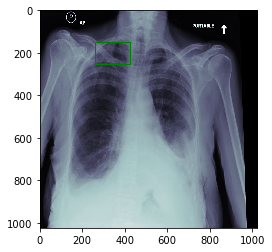

In [113]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

fig,ax = plt.subplots(1)

data, label = train_data.__getitem__(study)

img = data.asnumpy()*255
gtbox = label.asnumpy()*1024

# view CT scan
ax.imshow(img, cmap=plt.cm.bone, interpolation='none')

gt = patches.Rectangle((gtbox[0]-int(gtbox[2]/2),gtbox[1]-int(gtbox[3]/2)),gtbox[2],gtbox[3],linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(gt)

for n in range(cls.size):
    pred = patches.Rectangle((bbox[n][0].asscalar()-int(bbox[n][2].asscalar()/2),bbox[n][1].asscalar()-int(bbox[n][3].asscalar()/2)),bbox[n][2].asscalar(),bbox[n][3].asscalar(),linewidth=1,edgecolor='g',facecolor='none')
    ax.add_patch(pred)

plt.show()

In [114]:
bbox

[
 [342.3679   200.68361  167.33426  101.508896]
 <NDArray 4 @cpu(0)>]

In [115]:
label


[255. 147. 419. 245.]
<NDArray 4 @cpu(0)>

In [106]:
gtbox

array([ 49152., 626688., 224256., 700416.], dtype=float32)